In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
train_path = "./backend/src/backend/data/train.csv"
small_figsize = (5, 5)
medium_figsize = (10, 10)
df = pd.read_csv(train_path)
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [7]:
print(df.dtypes)

state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object


# Data Cleaning



## Convert "international_plan", "voice_mail_plan", "churn" to boolean

In [8]:
bool_cols = ["international_plan", "voice_mail_plan", "churn"]
for col in bool_cols:
    df[col] = df[col].replace("yes", True)
    df[col] = df[col].replace("no", False)
print(df.dtypes)

state                             object
account_length                     int64
area_code                         object
international_plan                  bool
voice_mail_plan                     bool
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                               bool
dtype: object


## Get rid of "area_code" prefix in "area code" column

In [9]:
df["area_code"] = df["area_code"].apply(lambda x: x.replace("area_code_", ""))

## Check for NAs

In [10]:
df.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

## Cast categorical columns

In [11]:
# this is experiental -> pd.NA does not work with pd.isnull()
# df = df.convert_dtypes()
df = df.astype({"state": "category", "area_code": "category", "international_plan": "category", "voice_mail_plan": "category", "churn": "category"})
df.dtypes

state                            category
account_length                      int64
area_code                        category
international_plan               category
voice_mail_plan                  category
number_vmail_messages               int64
total_day_minutes                 float64
total_day_calls                     int64
total_day_charge                  float64
total_eve_minutes                 float64
total_eve_calls                     int64
total_eve_charge                  float64
total_night_minutes               float64
total_night_calls                   int64
total_night_charge                float64
total_intl_minutes                float64
total_intl_calls                    int64
total_intl_charge                 float64
number_customer_service_calls       int64
churn                            category
dtype: object

## Define groups of columns

In [12]:
# native categorical variables:
state_group = ["state"]
area_code_group = ["area_code"]
plan_group = ["international_plan", "voice_mail_plan"]
churn_group = ["churn"]

# native numerical variables
account_length_group = ["account_length"]
messages_group = ["number_vmail_messages"]
total_minutes_group = ["total_day_minutes", "total_eve_minutes", "total_night_minutes", "total_intl_minutes"]
total_calls_group = ["total_day_calls", "total_eve_calls", "total_night_calls", "total_intl_calls", "number_customer_service_calls"]
total_charge_group = ["total_day_charge", "total_eve_charge", "total_night_charge", "total_intl_charge"]

# Remove variables if not important
important_variables = list(df.columns)
target_variables = "churn"
if "churn" in important_variables:
    important_variables.remove("churn")

# Plotting

In [13]:
rows = 1
single_figsize = (5 ,5)    

def plot_group(df, group, n_bins=30, cat=False, rel=True):
    group_df = df.loc[:, group]
    is_churn = df["churn"].astype("boolean")
    min_v = group_df.min().min()
    max_v = group_df.max().max()
    bins = np.linspace(min_v, max_v, n_bins)
        
    cols = (len(group_df.columns) // rows) + 1
    fig, axes = plt.subplots(rows, cols, figsize=(cols * single_figsize[0], rows * single_figsize[1]), sharey=True, sharex=True)
    
    for i, ax in enumerate(axes.ravel()):
        if i >= len(group_df.columns):
            fig.delaxes(ax)
        else:
            data = group_df.iloc[:, i]
                
            data_c = data[is_churn]
            data_nc = data[~is_churn]
            
            if cat:
                abs_t = pd.crosstab(data, df["churn"])
                rel_t = abs_t.div(abs_t.sum(1), axis=0)
                if rel:
                    rel_t.plot(kind="bar", ax=ax)
                else:
                    abs_t.plot(kind="bar", ax=ax)
                # data.value_counts().plot(kind="bar", ax=ax)
                #ax.bar(data_c.cat.categories, data_c.value_counts(),  label="churn")
                #ax.bar(data_nc.cat.categories, data_nc.value_counts(), label="no_churn")
                
            
            else:
                fig.supxlabel("Value")
                fig.supylabel("Counts")
                mu_c, sigma_c, median_c = round(data_c.mean(), 2), round(data_c.std(), 2), round(data_c.median(), 2)
                mu_nc, sigma_nc, median_nc = round(data_nc.mean(), 2), round(data_nc.std(), 2), round(data_nc.median(), 2)
    
                textstr = "mu_c={}\nmu_nc={}\nm_c={}\nm_nc={}\ns_c={}\ns_nc={}".format(mu_c, mu_nc, median_c, median_nc, sigma_c, sigma_nc)
                ax.text(0.7, 0.95, textstr, transform=ax.transAxes, verticalalignment="top")
            
                ax.hist(data_c, alpha=0.5, label="churn", bins=bins, color="red")
                ax.hist(data_nc, alpha=0.5, label="no churn", bins=bins, color="green")
                ax.legend(loc="upper left")
                ax.set_title(group_df.columns[i])
            #textstr = '\n'.join((
            #    r'$\mu_{c}=%.2f$' % (mu_c, ),
            #    r'$\mu_{nc}=%.2f$' % (mu_nc, ),
            #    r'$\mathrm{m}_{c}=%.2f$' % (median_c, ),
            #    r'$\mathrm{m}_{nc}=%.2f$' % (median_nc, ),
            #    r'$\sigma_{c}=%.2f$' % (sigma_c, ), 
            #    r'$\sigma_{nc}=%.2f$' % (sigma_nc, ), 
            #))
            
            
            

False    3652
True      598
Name: churn, dtype: int64

False    0.859294
True     0.140706
Name: churn, dtype: float64


C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:7: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  min_v = group_df.min().min()
C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:8: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_v = group_df.max().max()


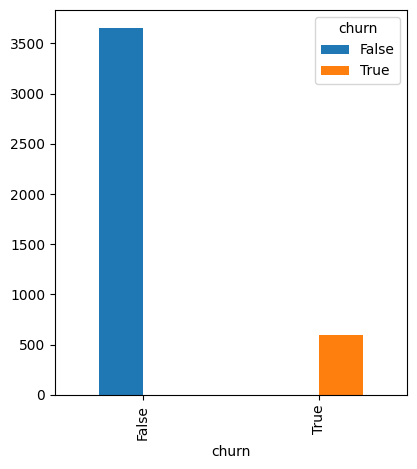

In [14]:
plot_group(df, churn_group, cat=True, rel=False)
counts = df["churn"].value_counts()
counts_norm = df["churn"].value_counts(normalize=True)
print(str(counts) + "\n")
print(counts_norm)

## **Accuracy Baseline: 86%**

# Categorical Variables:


## Describe categorical variables

In [15]:
df.describe(include="category")

,state,area_code,international_plan,voice_mail_plan,churn
count,4250,4250,4250,4250,4250
unique,51,3,2,2,2
top,WV,415,False,False,False
freq,139,2108,3854,3138,3652


## **Findings: area_code variable is either wrong or useless because only 3 unique values**

## Mean of numerical variables grouped by categorical variables

In [16]:
df.groupby(state_group).mean().sort_values("number_customer_service_calls", ascending=False)

C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\1824472281.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(state_group).mean().sort_values("number_customer_service_calls", ascending=False)


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
state,,,,,,,,,,,,,,,
AR,94.816901,10.014085,169.452113,97.676056,28.807324,192.081690,99.450704,16.327324,203.125352,102.788732,9.141127,10.194366,4.605634,2.752676,1.816901
CO,98.225000,7.887500,173.491250,97.650000,29.494250,208.077500,99.712500,17.686375,191.708750,96.300000,8.627500,9.866250,4.100000,2.664250,1.800000
ME,95.471910,7.337079,184.961798,98.337079,31.444270,201.703371,104.011236,17.145056,201.507865,101.561798,9.067753,10.014607,4.539326,2.704719,1.786517
OK,101.064103,6.628205,191.917949,98.948718,32.626282,196.876923,103.076923,16.735641,200.365385,98.205128,9.015897,10.470513,4.525641,2.828205,1.769231
GA,100.015625,8.156250,178.448438,102.921875,30.336562,205.642188,104.937500,17.479688,200.018750,102.812500,9.000937,10.537500,4.281250,2.845937,1.750000
DE,97.675000,7.850000,182.797500,99.962500,31.076125,207.815000,96.087500,17.664750,205.265000,98.825000,9.237125,10.546250,4.225000,2.849000,1.737500
IN,98.144578,8.132530,188.319277,106.156627,32.014940,205.278313,98.566265,17.448675,206.409639,100.349398,9.288313,9.909639,4.120482,2.675783,1.734940
OR,99.454545,6.656566,177.946465,95.595960,30.251717,201.932323,97.323232,17.164646,200.100000,104.969697,9.004747,10.501010,4.333333,2.835859,1.727273
MO,100.350000,6.312500,173.125000,100.200000,29.432375,201.532500,99.362500,17.130375,211.418750,99.637500,9.513875,9.857500,5.037500,2.662000,1.700000


In [17]:
t_ac = pd.crosstab(df["state"], df["churn"])

<AxesSubplot: xlabel='state'>

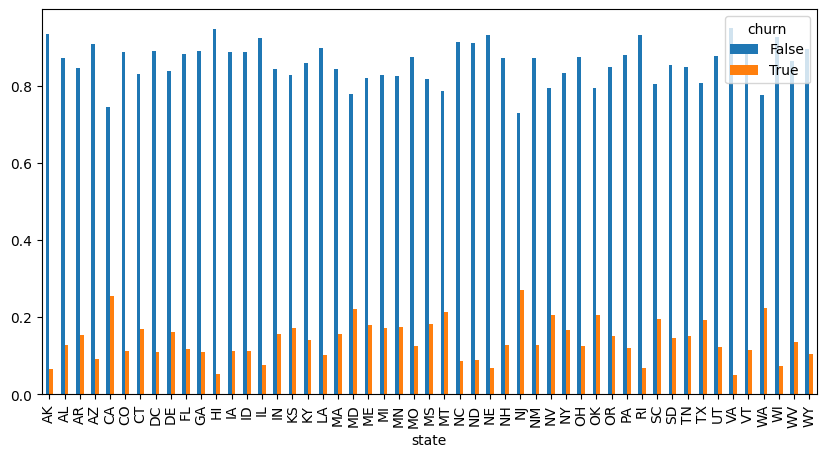

In [18]:
t_ac.div(t_ac.sum(1), axis=0).plot(kind="bar", figsize=(single_figsize[0] * 2, single_figsize[1]))

## **Findings: State variable is important** 

## Group data by area code

In [19]:
df.groupby("area_code").mean()

C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\3661007488.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("area_code").mean()


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
area_code,,,,,,,,,,,,,,,
408,101.550645,7.551565,178.401381,99.162983,30.328766,201.233794,100.697974,17.105018,198.291621,99.145488,8.923232,10.109945,4.388582,2.730341,1.571823
415,100.218691,7.761860,181.683871,100.931689,30.886850,199.099383,100.038899,16.923672,201.460484,99.897059,9.065897,10.352751,4.490038,2.795745,1.525142
510,98.919508,7.454545,179.327462,98.627841,30.486155,201.228883,99.914773,17.104782,200.966004,100.438447,9.043561,10.213352,4.338068,2.758002,1.613636


C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:7: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  min_v = group_df.min().min()
C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:8: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_v = group_df.max().max()


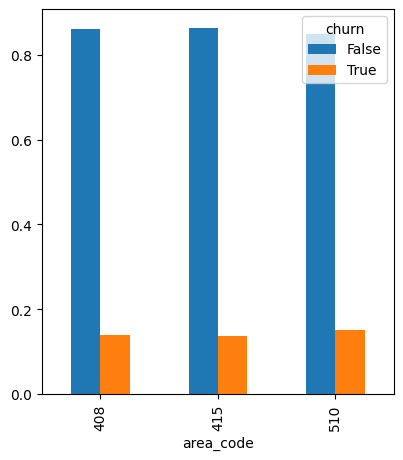

In [20]:
plot_group(df, area_code_group, cat=True, rel=True)

## **area_code variable is NOT important**

In [21]:
if "area_code" in important_variables:
    important_variables.remove("area_code")

## Group by type of plan

## Do users have a voicemail plan but do not use voicemail?

In [22]:
mask = df["voice_mail_plan"] == True
print(f"Number of users with voicemail plan: {mask.sum()}")

mask = (df["number_vmail_messages"] == 0) & (df["voice_mail_plan"] == True)
# df["vmail_used"] = ~mask
print(f"Number of users with voicemail plan but not a single sent voicemail: {mask.sum()}")

mask = (df["number_vmail_messages"] <= 10) & (df["voice_mail_plan"] == True)
print(f"Number of users with voicemail plan but less than ten sent voicemails: {mask.sum()}")

df[mask].head()

Number of users with voicemail plan: 1112
Number of users with voicemail plan but not a single sent voicemail: 1
Number of users with voicemail plan but less than ten sent voicemails: 10


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1222,ID,55,510,False,True,8,222.5,104,37.83,171.5,94,14.58,377.5,114,16.99,9.7,2,2.62,1,False
1680,SC,114,510,False,True,4,141.3,96,24.02,230.4,88,19.58,223.7,85,10.07,9.4,3,2.54,3,False
1868,OH,132,415,False,True,10,182.9,54,31.09,292.4,68,24.85,142.3,116,6.40,11.5,4,3.11,0,False
2048,DE,183,415,False,True,8,86.5,119,14.71,285.2,97,24.24,180.4,133,8.12,8.7,2,2.35,2,False
2852,WY,115,415,True,True,6,140.1,125,23.82,157.9,100,13.42,249.4,96,11.22,10.1,3,2.73,1,False


## **Only a single user does not use voicemail with voicemail plan**

In [23]:
df.groupby("voice_mail_plan").mean()

C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\3970848372.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("voice_mail_plan").mean()


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
voice_mail_plan,,,,,,,,,,,,,,,
False,100.196941,0.000000,180.280593,100.025494,30.648279,199.815519,100.173359,16.984532,199.991874,99.745379,8.999783,10.242766,4.434672,2.766048,1.575844
True,100.347122,29.168165,180.200360,99.573741,30.634532,201.185252,100.185252,17.101025,202.040468,100.105216,9.091924,10.293615,4.402878,2.779829,1.511691


C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:7: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  min_v = group_df.min().min()
C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:8: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_v = group_df.max().max()


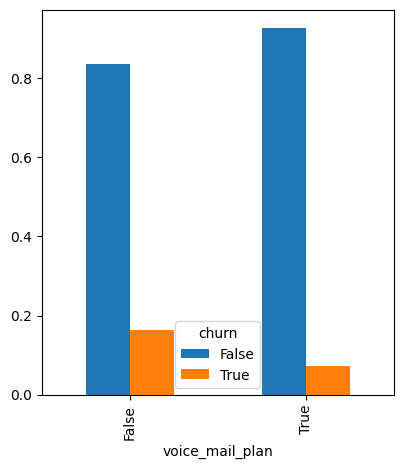

In [24]:
plot_group(df, ["voice_mail_plan"], cat=True)

## Do users have international plan but do not use international calls?

In [25]:
mask = df["international_plan"] == True
print(f"Number of users with international plan: {mask.sum()}")

mask = (df["total_intl_calls"] == 0) & (df["international_plan"] == True)
print(f"Number of users with international plan but zero international calls: {mask.sum()}")
# df["intl_calls_used"] = ~mask

mask = (df["total_intl_calls"] <= 10) & (df["international_plan"] == True)
print(f"Number of users with international plan but less than 10 international calls: {mask.sum()}")
df[mask].head()

Number of users with international plan: 396
Number of users with international plan but zero international calls: 1
Number of users with international plan but less than 10 international calls: 385


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
2,OH,84,408,True,False,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
3,OK,75,415,True,False,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,MO,147,415,True,False,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
7,WV,141,415,True,True,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False
30,AK,136,415,True,True,33,203.9,106,34.66,187.6,99,15.95,101.7,107,4.58,10.5,6,2.84,3,False


## **Only a single user does not use international calls with international plan**

In [26]:
df.groupby("international_plan").mean()

C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\3008517965.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("international_plan").mean()


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
international_plan,,,,,,,,,,,,,,,
False,99.892060,7.611053,179.566113,99.845096,30.526785,199.795693,100.195641,16.982870,200.861858,99.793461,9.038921,10.235003,4.420861,2.763970,1.562792
True,103.585859,7.833333,187.008838,100.512626,31.792096,203.854798,99.989899,17.327828,197.277525,100.287879,8.877626,10.461111,4.479798,2.824975,1.522727


C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:7: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  min_v = group_df.min().min()
C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2775211009.py:8: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_v = group_df.max().max()


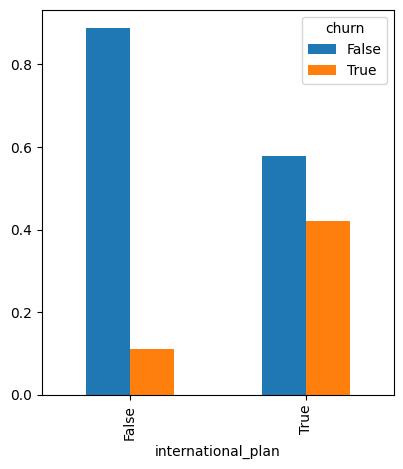

In [27]:
plot_group(df, ["international_plan"], cat=True, rel=True)

## **Almost everbody with an international plan churned!!**

## **international_plan and voice_mail_plan are important**

# Numerical Variables:
## Describe numerical variables:

In [28]:
df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,100.236235,7.631765,180.259600,99.907294,30.644682,200.173906,100.176471,17.015012,200.527882,99.839529,9.023892,10.256071,4.426353,2.769654,1.559059
std,39.698401,13.439882,54.012373,19.850817,9.182096,50.249518,19.908591,4.271212,50.353548,20.093220,2.265922,2.760102,2.463069,0.745204,1.311434
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,73.000000,0.000000,143.325000,87.000000,24.365000,165.925000,87.000000,14.102500,167.225000,86.000000,7.522500,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,180.450000,100.000000,30.680000,200.700000,100.000000,17.060000,200.450000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,16.000000,216.200000,113.000000,36.750000,233.775000,114.000000,19.867500,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000
max,243.000000,52.000000,351.500000,165.000000,59.760000,359.300000,170.000000,30.540000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


## Mean of numerical variables grouped by churn

In [29]:
df.groupby("churn").mean()

C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\2504763180.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby("churn").mean()


,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
churn,,,,,,,,,,,,,,,
False,99.924973,8.177437,175.555093,99.813801,29.844948,198.570674,100.231380,16.878743,199.577519,99.942771,8.981131,10.194441,4.460570,2.753018,1.441676
True,102.137124,4.299331,208.990134,100.478261,35.528679,209.964883,99.841137,17.847207,206.331773,99.209030,9.285033,10.632441,4.217391,2.871254,2.275920


## Churners have:
1. Fewer number_vmail_messgaes
2. More total_day_minutes
3. More total_day_charge
4. More total_eve_minutes
5. More total_eve_charge
6. More total_night_minutes
7. More total_night_charge
8. More number_customer_service_calls
9. NOT higher number of calls in every daytime

## **Churners have longer calls**



## Account length

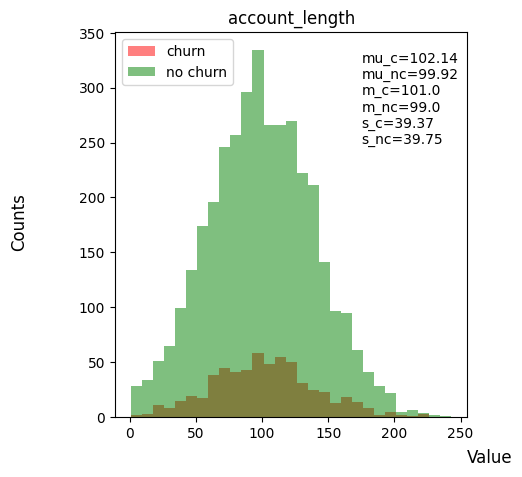

In [30]:
plot_group(df, account_length_group)

## **Account length is NOT important**

In [31]:
if "account_length" in important_variables:
    important_variables.remove("account_length")

## Total voicemail messages

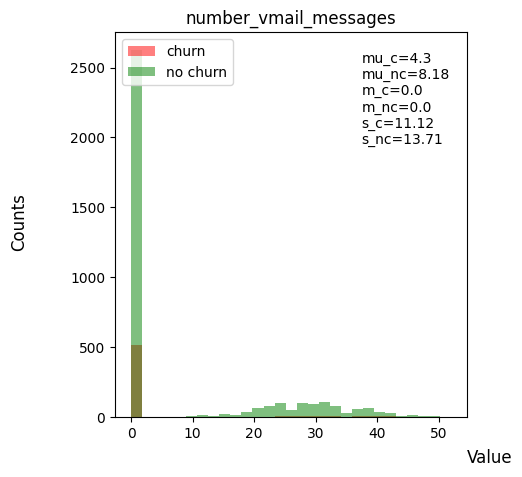

In [32]:
plot_group(df, messages_group)

## **Most users do not send voice messages**

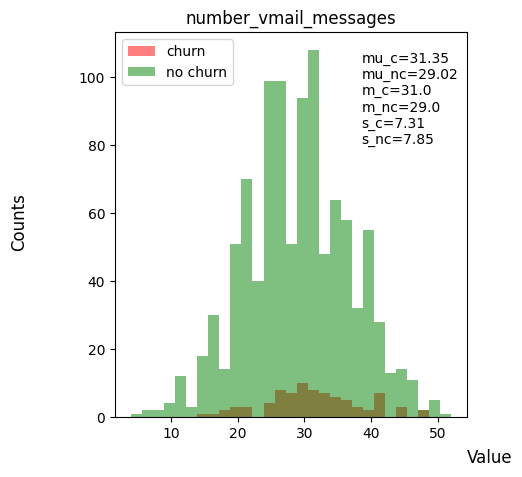

In [33]:
mask = df["number_vmail_messages"] > 0
vmail_user_df = df[mask]
no_vmail_user_df = df[~mask]
plot_group(vmail_user_df, ["number_vmail_messages"])

<AxesSubplot: >

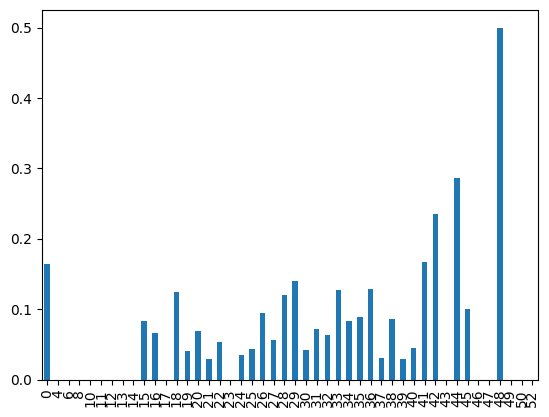

In [34]:
(df[df["churn"] == True]["number_vmail_messages"].value_counts() / df["number_vmail_messages"].value_counts()).plot(kind="bar")

## Total minutes by daytime

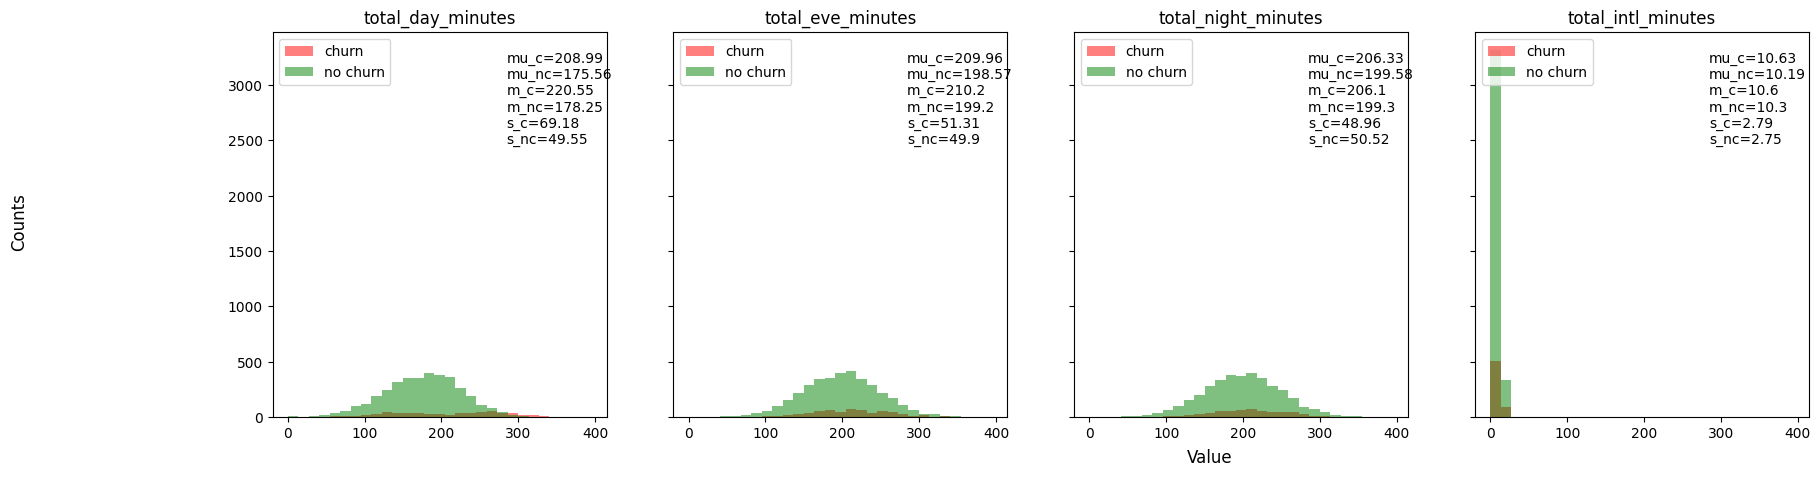

In [35]:
plot_group(df, total_minutes_group)

## **International minutes are very small for churn and no-churn**

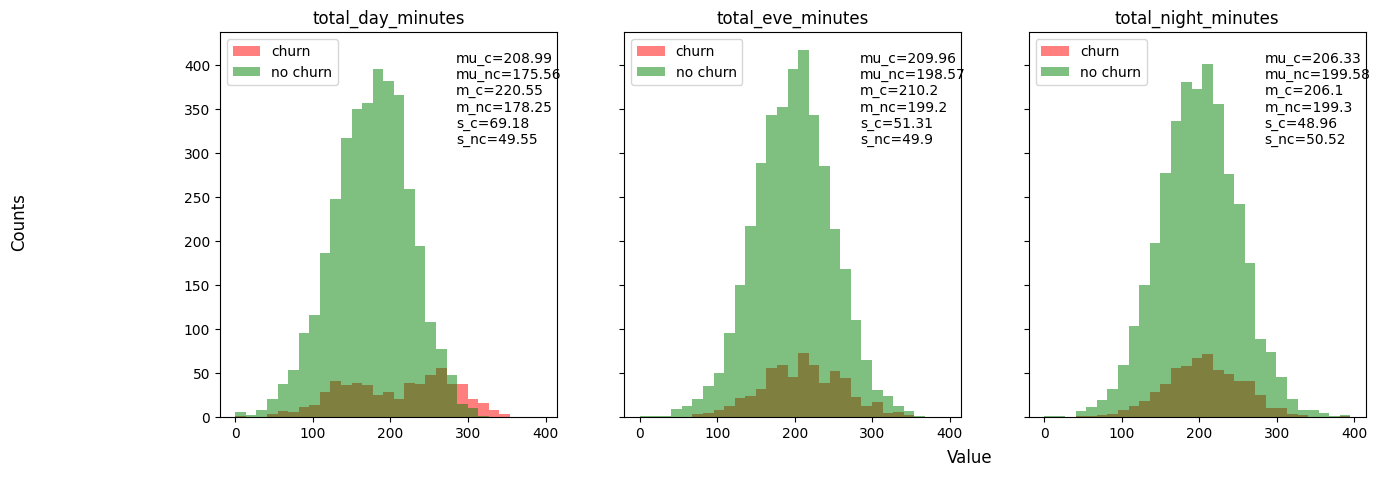

In [36]:
plot_group(df, ["total_day_minutes", "total_eve_minutes", "total_night_minutes"])

## **1. Day, evening and night minutes are almost identical distributed for churners.**
## **2. No-churners have different distribution for day minutes (two peaks)**

In [37]:
if "total_eve_minutes" in important_variables:
    important_variables.remove("total_eve_minutes")

if "total_night_minutes" in important_variables:
    important_variables.remove("total_night_minutes")

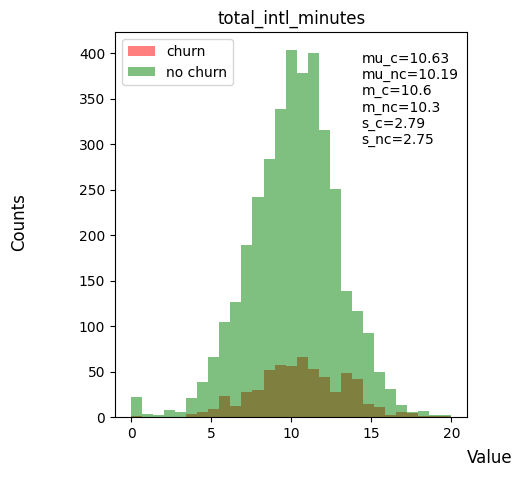

In [38]:
plot_group(df, ["total_intl_minutes"], n_bins=30)

## **total_intl_minutes are NOT important**

In [39]:
if "total_intl_minutes" in important_variables:
    important_variables.remove("total_intl_minutes")

## Total calls by daytime

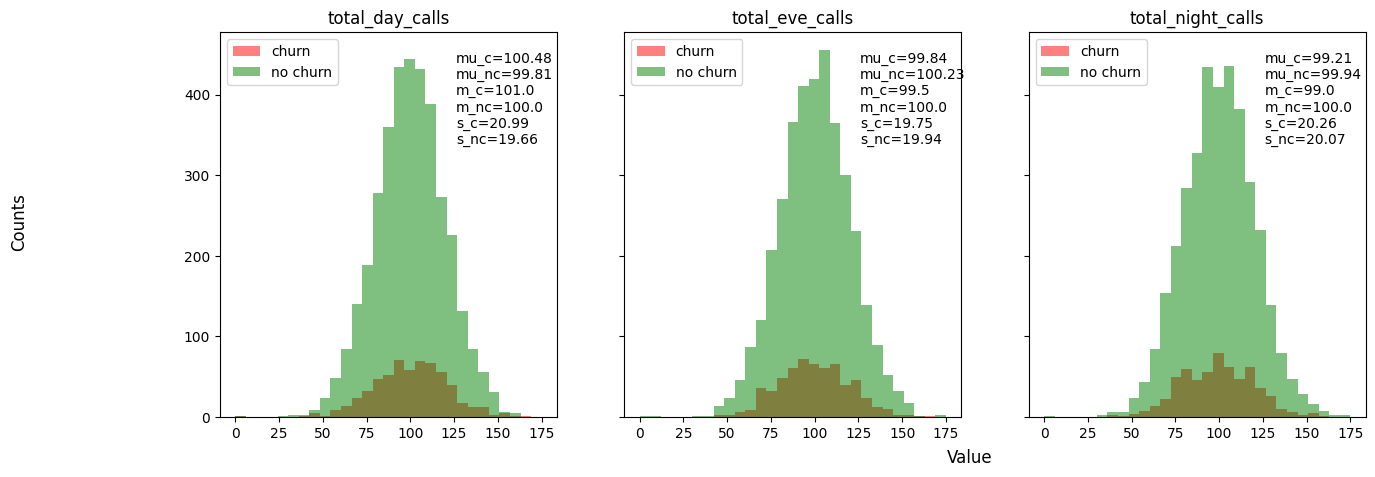

In [40]:
plot_group(df, ["total_day_calls", "total_eve_calls", "total_night_calls"])

## **Number of day, evening-, and night calls are almost identically distributed for churn and no-churn.**

## **total_day_calls, total_eve_calls and total_night calls are NOT important**

In [41]:
if "total_day_calls" in important_variables:
    important_variables.remove("total_day_calls")
    
if "total_eve_calls" in important_variables:
    important_variables.remove("total_eve_calls")
    
if "total_night_calls" in important_variables:
    important_variables.remove("total_night_calls")

## Total international calls

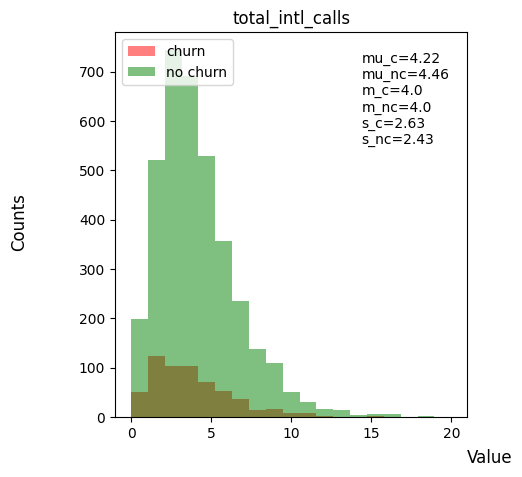

In [42]:
plot_group(df, ["total_intl_calls"], n_bins=20)

## 1. **Most people do use a moderate amount of international calls**
## 2. **Total intl_calls not important, because no difference in churn**

In [43]:
if "total_intl_calls" in important_variables:
    important_variables.remove("total_intl_calls")

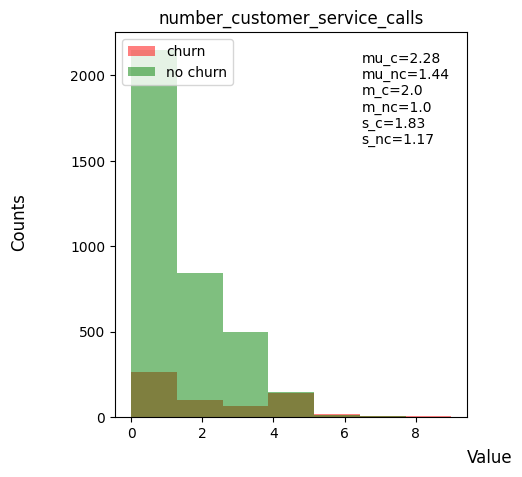

In [44]:
plot_group(df, ["number_customer_service_calls"], n_bins=8)

## **If customer service calls are greater than 4, churn rate is very high**

## Total charge

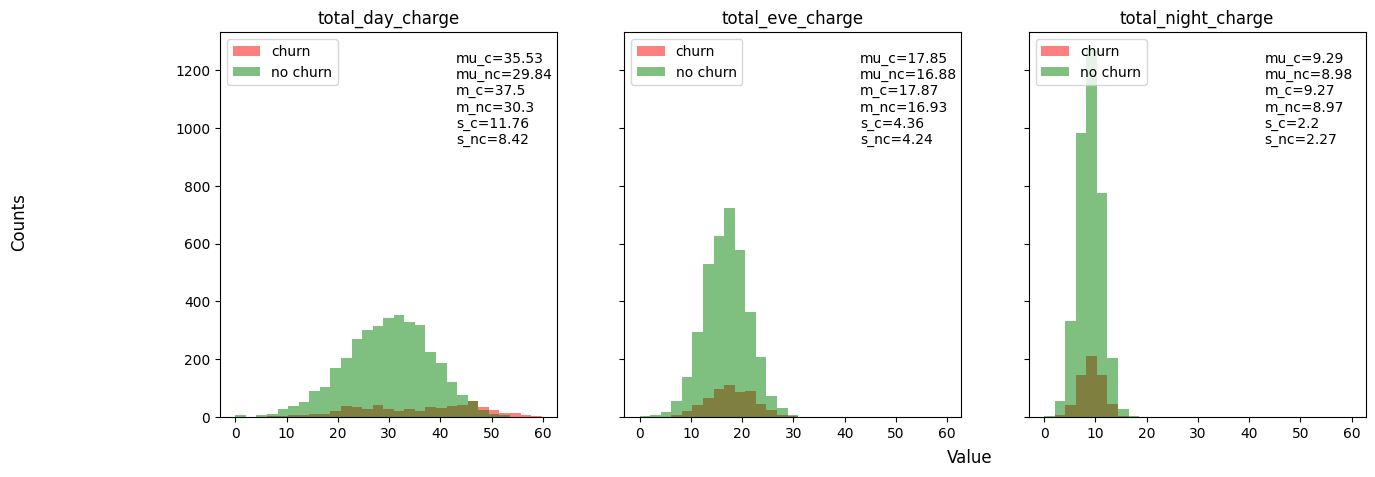

In [45]:
plot_group(df, ["total_day_charge", "total_eve_charge", "total_night_charge"])

## **Total day charge of churners is much higher than for no churners**

In [46]:
if "total_eve_charge" in important_variables:
    important_variables.remove("total_eve_charge")
    
if "total_night_charge" in important_variables:
    important_variables.remove("total_night_charge")

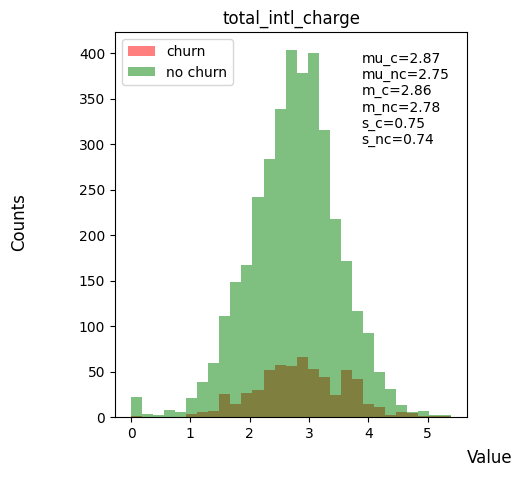

In [47]:
plot_group(df, ["total_intl_charge"])

In [48]:
if "total_intl_charge" in important_variables:
    important_variables.remove("total_intl_charge")

In [49]:
important_variables
corr_df = df.corr()

C:\Users\dmanns\AppData\Local\Temp\ipykernel_9752\3411139350.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


# Feature Engineering

## Total, aggregated calls over daytime

In [119]:
df["total_calls"] = df["total_eve_calls"] + df["total_night_calls"] + df["total_day_calls"] + df["total_intl_calls"]
df["total_minutes"] = df["total_eve_minutes"] + df["total_night_minutes"] + df["total_day_minutes"] + df["total_intl_minutes"]
df["total_charge"] = df["total_eve_charge"] + df["total_night_charge"] + df["total_day_charge"] + df["total_intl_charge"]

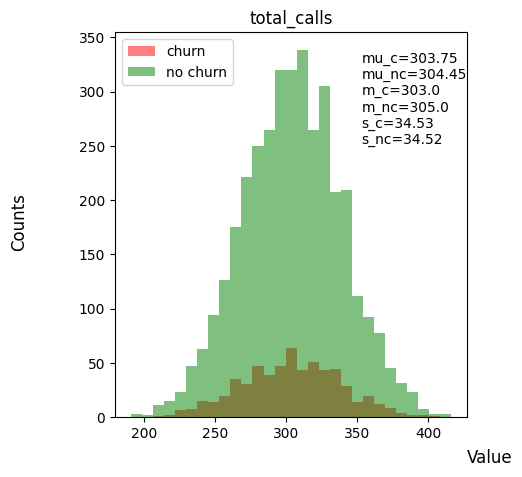

In [120]:
plot_group(df, ["total_calls"])

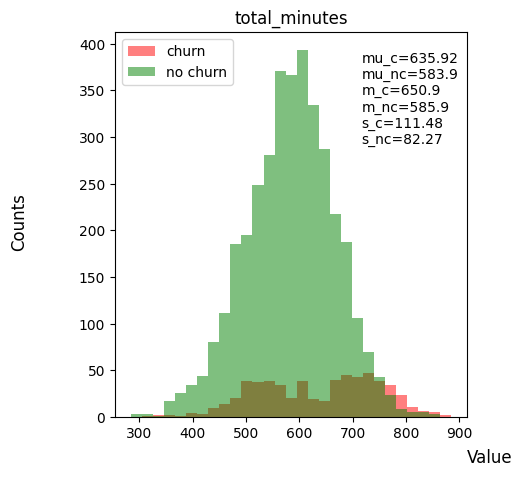

In [121]:
plot_group(df, ["total_minutes"])

In [122]:
important_variables.append("total_minutes")

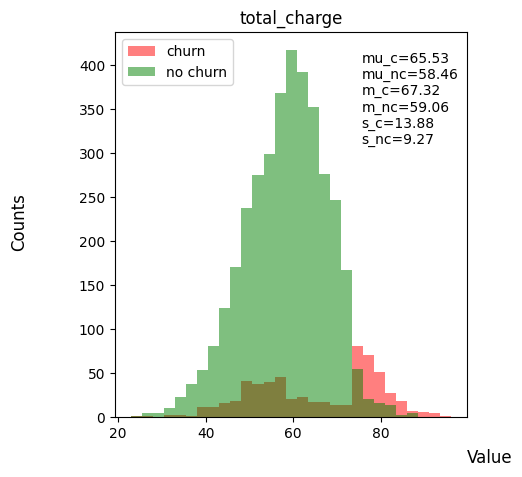

In [123]:
plot_group(df, ["total_charge"])

In [124]:
important_variables.append("total_charge")

## Average duration (minutes) per call and daytime

In [125]:
df["avg_day_call_duration"] = df["total_day_minutes"].divide(df["total_day_calls"]).round(2)
df["avg_eve_call_duration"] = df["total_eve_minutes"].divide(df["total_eve_calls"]).round(2)
df["avg_night_call_duration"] = df["total_night_minutes"].divide(df["total_night_calls"]).round(2)
df["avg_intl_call_duration"] = df["total_intl_minutes"].divide(df["total_intl_calls"]).round(2)

call_duration_group = ["avg_day_call_duration", "avg_eve_call_duration", "avg_night_call_duration", "avg_intl_call_duration"]

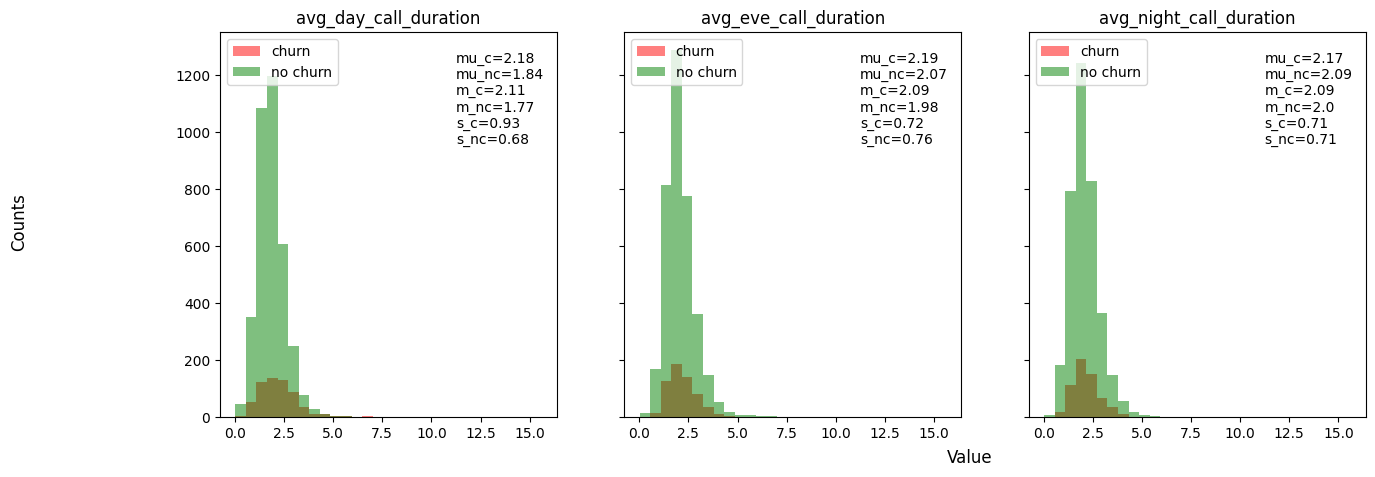

In [126]:
plot_group(df, ["avg_day_call_duration", "avg_eve_call_duration", "avg_night_call_duration"])

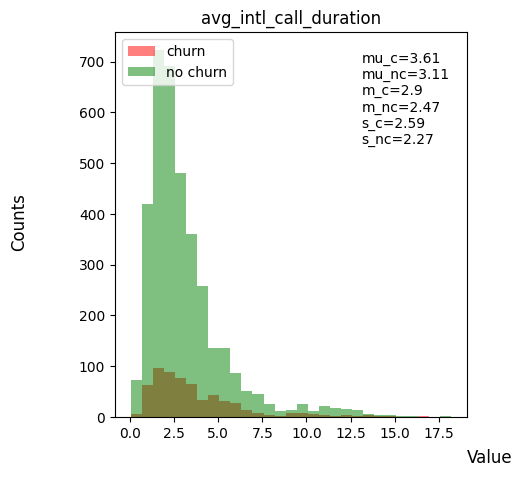

In [127]:
plot_group(df, ["avg_intl_call_duration"])

## Average chargerate per minute

In [128]:
df["avg_day_minute_charge"] = df["total_day_charge"].divide(df["total_day_minutes"]).round(2)
df["avg_eve_minute_charge"] = df["total_eve_charge"].divide(df["total_eve_minutes"]).round(2)
df["avg_night_minute_charge"] = df["total_night_charge"].divide(df["total_night_minutes"]).round(2)
df["avg_intl_minute_charge"] = df["total_intl_charge"].divide(df["total_intl_minutes"]).round(2)

minute_charge_group = ["avg_day_minute_charge", "avg_eve_minute_charge","avg_night_minute_charge", "avg_intl_minute_charge"]

## Fill na values in engineered variables when divisor was 0


In [129]:
df[call_duration_group + minute_charge_group] = df[call_duration_group + minute_charge_group].fillna(value=0.0)

df.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
total_calls                      0
total_minutes                    0
total_charge                     0
avg_day_call_duration            0
avg_eve_call_duration            0
avg_night_call_duration          0
avg_intl_call_duration           0
avg_day_minute_charge            0
avg_eve_minute_charg

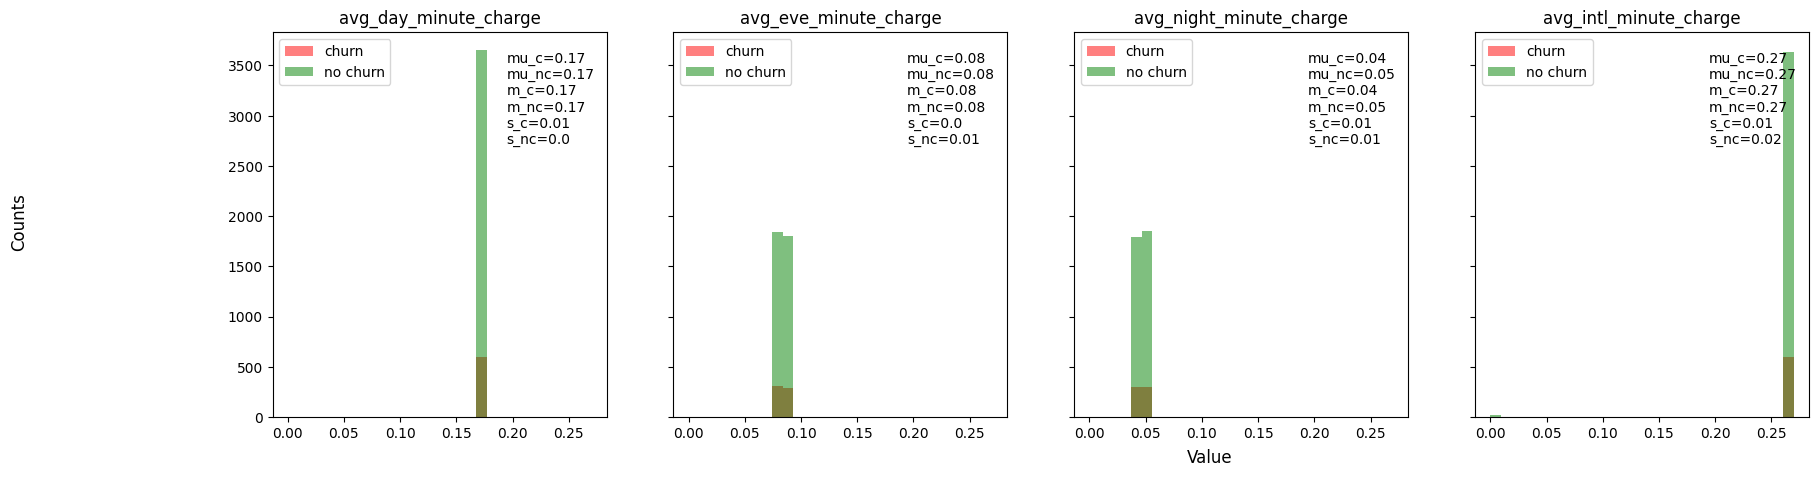

In [130]:
plot_group(df, ["avg_day_minute_charge", "avg_eve_minute_charge","avg_night_minute_charge", "avg_intl_minute_charge"])

## **We see that there are no variable charge rates per minute**

In [ ]:
corr_df = df.corr()

C:\Users\dmanns\AppData\Local\Temp\ipykernel_10748\1779705247.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


<AxesSubplot: >

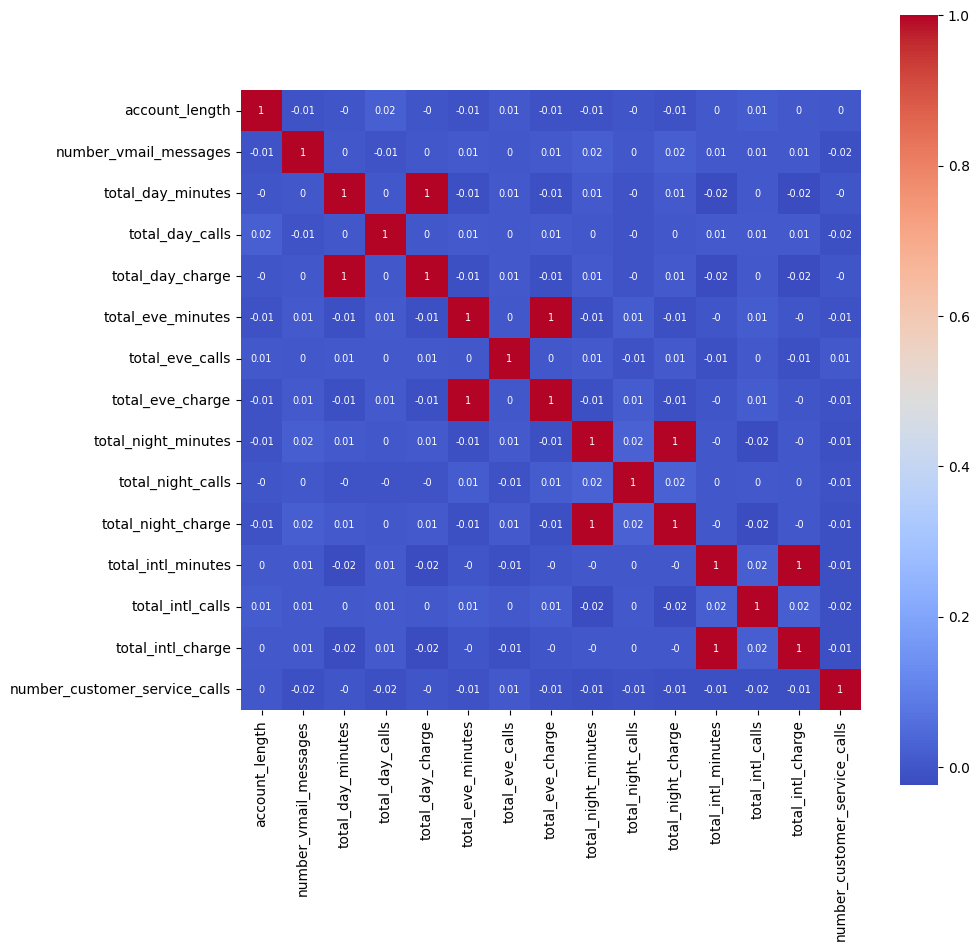

In [50]:
# check 5 percent of vmail messages persons and check for churn
# no vmail plan but still more than 0 vmail messages?
#mask = np.tril(np.ones(corr_df.shape, dtype=bool))
#data = corr_df.where(mask)
fig, ax1 = plt.subplots(1,1, figsize=(single_figsize[0] * 2, single_figsize[1] * 2))
sns.heatmap(corr_df, cmap="coolwarm", ax=ax1, square=True, annot=corr_df.round(2), annot_kws={"fontsize": 7})

In [138]:
important_variables

['state',
 'international_plan',
 'voice_mail_plan',
 'number_vmail_messages',
 'total_day_minutes',
 'total_day_charge',
 'number_customer_service_calls',
 'total_minutes',
 'total_charge']